# Evaluators

At a high-level, an evaluator judges an invocation of your LLM application against a reference example, and returns an evaluation score.

In LangSmith evaluators, we represent this process as a function that takes in a Run (representing the LLM app invocation) and an Example (representing the data point to evaluate), and returns Feedback (representing the evaluator's score of the LLM app invocation).

![Evaluator](../../images/evaluator.png)

Here is an example of a very simple custom evaluator that compares the output of a model to the expected output in the dataset:

In [1]:
from langsmith.schemas import Example, Run

def correct_label(inputs: dict, reference_outputs: dict, outputs: dict) -> dict:
  score = outputs.get("output") == reference_outputs.get("label")
  return {"score": int(score), "key": "correct_label"}

### LLM-as-Judge Evaluation

LLM-as-judge evaluators use LLMs to score system output. To use them, you typically encode the grading rules / criteria in the LLM prompt. They can be reference-free (e.g., check if system output contains offensive content or adheres to specific criteria). Or, they can compare task output to a reference (e.g., check if the output is factually accurate relative to the reference).

Here is an example of how you might define an LLM-as-judge evaluator with structured output

In [ ]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""

In [2]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/Lenovo/Documents/code/mat496/.env", override=True)

True

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

class Similarity_Score(BaseModel):
    similarity_score: int = Field(description="Semantic similarity score between 1 and 10, where 1 means unrelated and 10 means identical.")

# NOTE: This is our evaluator
def compare_semantic_similarity(inputs: dict, reference_outputs: dict, outputs: dict):
    input_question = inputs["question"]
    reference_response = reference_outputs["output"]
    run_response = outputs["output"]
    
    parser = PydanticOutputParser(pydantic_object=Similarity_Score)
    
    prompt = f"""You are a semantic similarity evaluator. Compare the meanings of two responses to a question, 
Reference Response and New Response, where the reference is the correct answer, and we are trying to judge if the new response is similar. 
Provide a score between 1 and 10, where 1 means completely unrelated, and 10 means identical in meaning.

Question: {input_question}
Reference Response: {reference_response}
Run Response: {run_response}

{parser.get_format_instructions()}"""
    
    response = llm.invoke(prompt)
    similarity_score = parser.parse(response.content)
    
    return {"score": similarity_score.similarity_score, "key": "similarity"}

Let's try this out!

NOTE: We purposely made this answer wrong, so we expect to see a low score.

In [6]:
# From Dataset Example USING MY CUSTOM DATASET
inputs = {
  "question":" Who wrote the Name of the Wind?"
}
reference_outputs = {
  "output": "The Name of the Wind was written by Patrick Rothfuss. It's the first book in The Kingkiller Chronicle series, following the story of Kvothe, a legendary figure recounting his past. The book was published in 2007 and became a bestseller."
}


# From Run
outputs = {
  "output": "The author is brandon sanderson. Brandon Sanderson is known for creating hard magic systems with clear rules and limitations. His magic systems are logical and internally consistent, allowing readers to understand and predict how magic works. Examples include Allomancy in Mistborn and Stormlight in The Stormlight Archive."
}

similarity_score = compare_semantic_similarity(inputs, reference_outputs, outputs)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 1, 'key': 'similarity'}


You can also define evaluators using Run and Example directly!

In [7]:
from langsmith.schemas import Run, Example
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

# Use the same Gemini client from your app
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

class Similarity_Score(BaseModel):
    similarity_score: int = Field(description="Semantic similarity score between 1 and 10, where 1 means unrelated and 10 means identical.")

def compare_semantic_similarity_v2(root_run: Run, example: Example):
    input_question = example["inputs"]["question"]
    reference_response = example["outputs"]["output"]
    run_response = root_run["outputs"]["output"]
    
    parser = PydanticOutputParser(pydantic_object=Similarity_Score)
    
    prompt = f"""You are a semantic similarity evaluator. Compare the meanings of two responses to a question, 
Reference Response and New Response, where the reference is the correct answer, and we are trying to judge if the new response is similar. 
Provide a score between 1 and 10, where 1 means completely unrelated, and 10 means identical in meaning.

Question: {input_question}
Reference Response: {reference_response}
Run Response: {run_response}

{parser.get_format_instructions()}"""
    
    response = llm.invoke(prompt)
    similarity_score = parser.parse(response.content)
    
    return {"score": similarity_score.similarity_score, "key": "similarity"}

In [8]:
sample_run = {
  "name": "Sample Run",
  "inputs": {
    "question": "Who wrote the Name of the Wind?"
  },
  "outputs": {
    "output": "The author is brandon sanderson. Brandon Sanderson is known for creating hard magic systems with clear rules and limitations. His magic systems are logical and internally consistent, allowing readers to understand and predict how magic works. Examples include Allomancy in Mistborn and Stormlight in The Stormlight Archive."
  },
  "is_root": True,
  "status": "success",
  "extra": {
    "metadata": {
      "key": "value"
    }
  }
}

sample_example = {
  "inputs": {
    "question": "Who wrote the Name of the Wind?"
  },
  "outputs": {
    "output": "The Name of the Wind was written by Patrick Rothfuss. It's the first book in The Kingkiller Chronicle series, following the story of Kvothe, a legendary figure recounting his past. The book was published in 2007 and became a bestseller."
  },
  "metadata": {
    "dataset_split": [
      "AI generated",
      "base"
    ]
  }
}

similarity_score = compare_semantic_similarity_v2(sample_run, sample_example)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 1, 'key': 'similarity'}


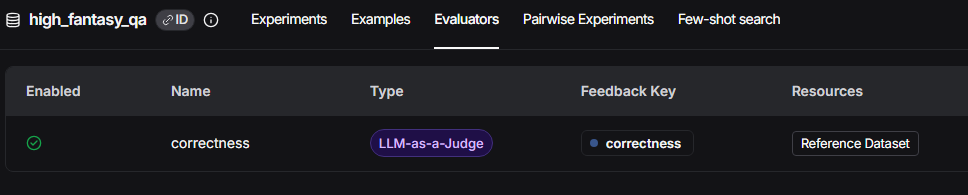 
#custom llm as judge evaluator

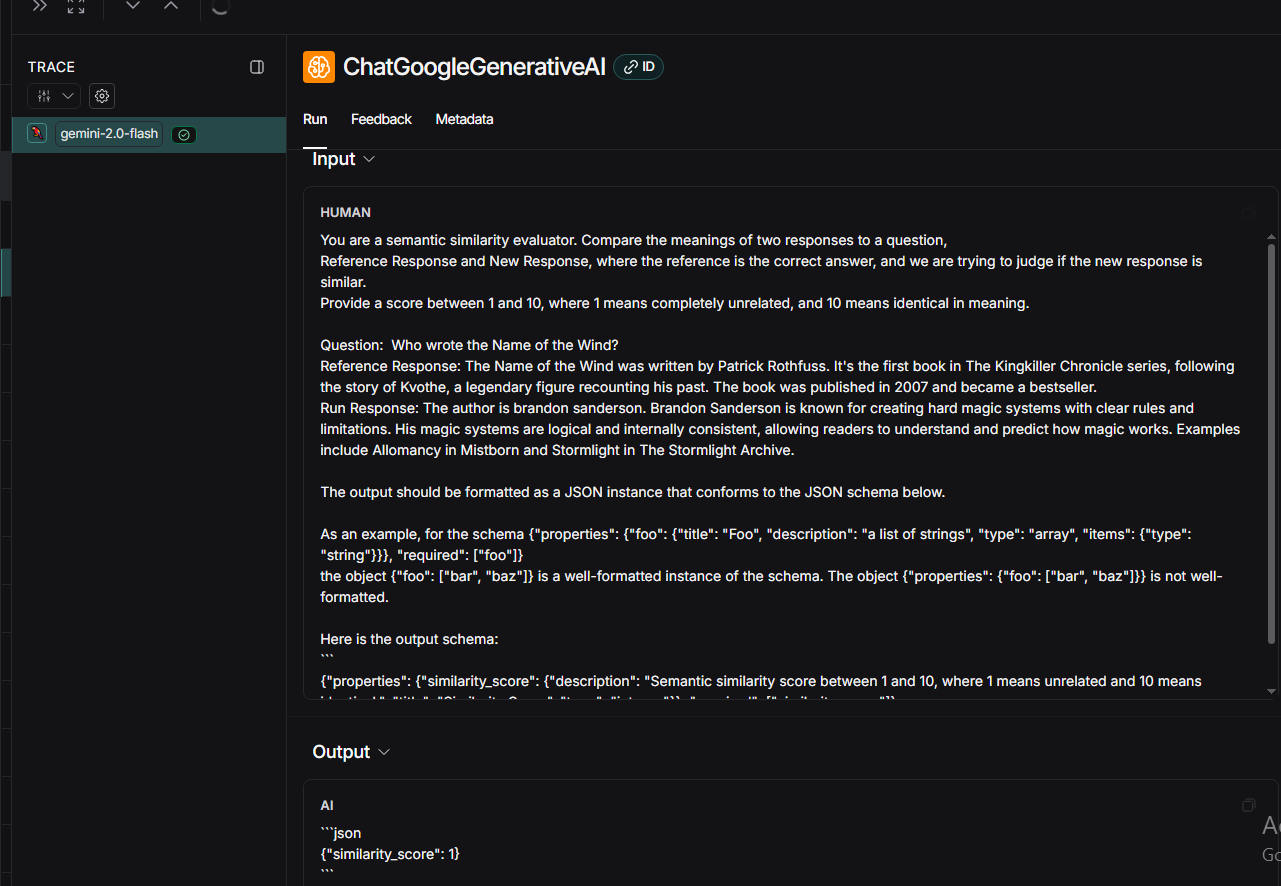